<a href="https://colab.research.google.com/github/joselcadavid/LSTM-EEG/blob/main/02_modelo_multiclase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import (classification_report, confusion_matrix, cohen_kappa_score,
                            balanced_accuracy_score, accuracy_score)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, LSTM, Dense, Dropout,
                                     BatchNormalization, GaussianNoise)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

In [ ]:
# =============================================================================
# CONFIGURACIÓN OPTIMIZADA
# =============================================================================
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# CRÍTICO: Secuencias más largas y mayor overlap para datasets pequeños
SEQ_LENGTH = 20      # Más contexto temporal
STRIDE = 2           # Mucho overlap = más ejemplos de entrenamiento
USE_AUGMENTATION = True
N_AUGMENTATIONS = 3  # Multiplicar datos por N

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# =============================================================================
# 1. CARGAR DATOS
# =============================================================================
#path = "https://raw.githubusercontent.com/joselcadavid/Datos-EEG/b1e42aed7c72cbad3d65f252ffc22be7776f9fc5/EEG_WELCH_PermEntropy_por_banda.csv"
#df = pd.read_csv(path, sep=";")
df = pd.read_csv("/content/drive/MyDrive/Proyecto_DeepLearning/Entrega 2/EEG_WELCH_PermEntropy_por_banda.csv", sep=";")


meta_cols = ["subject", "diagnosis", "window_index", "start_time_s", "end_time_s"]
feature_cols = [c for c in df.columns if c not in meta_cols]

print(f"Features: {len(feature_cols)}")
print(f"Ventanas totales: {len(df)}")

# Verificar si hay NaN
if df[feature_cols].isnull().any().any():
    print("⚠ Advertencia: Hay valores NaN. Rellenando con mediana...")
    df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())

subjects_df = df[["subject", "diagnosis"]].drop_duplicates().reset_index(drop=True)
print(f"Sujetos: {len(subjects_df)}")
print(f"\nDistribución diagnósticos:\n{subjects_df['diagnosis'].value_counts()}")

Features: 128
Ventanas totales: 5724
Sujetos: 124

Distribución diagnósticos:
diagnosis
CTR    38
GG     37
GU     31
DCL    18
Name: count, dtype: int64


In [ ]:
# =============================================================================
# 2. SPLIT ESTRATIFICADO
# =============================================================================
test_frac = 0.2
rng = np.random.default_rng(RANDOM_SEED)

train_subjects = []
test_subjects = []

print("\nDivisión train/test:")
for diag, group in subjects_df.groupby("diagnosis"):
    subs = group["subject"].values.copy()
    rng.shuffle(subs)
    n_test = max(1, int(round(len(subs) * test_frac)))
    test_subjects.extend(subs[:n_test])
    train_subjects.extend(subs[n_test:])
    print(f"  {diag}: train={len(subs[n_test:])}, test={n_test}")


División train/test:
  CTR: train=30, test=8
  DCL: train=14, test=4
  GG: train=30, test=7
  GU: train=25, test=6


In [ ]:
# =============================================================================
# 3. DATA AUGMENTATION FUNCTIONS
# =============================================================================
def add_noise(X, noise_level=0.02):
    """Añade ruido gaussiano"""
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise

def scale_data(X, scale_factor=0.1):
    """Escala los datos ligeramente"""
    scale = 1 + np.random.uniform(-scale_factor, scale_factor, (X.shape[0], 1, 1))
    return X * scale

def shift_data(X, shift_max=2):
    """Desplaza temporalmente (circular shift)"""
    shift = np.random.randint(-shift_max, shift_max+1)
    return np.roll(X, shift, axis=1)

def time_warp(X, sigma=0.2):
    """Time warping suave"""
    seq_len = X.shape[1]
    n_features = X.shape[2]

    # Crear warping smoothe
    warp = np.cumsum(np.random.normal(1.0, sigma, seq_len))
    warp = warp / warp[-1] * (seq_len - 1)

    X_warped = np.zeros_like(X)
    for i in range(X.shape[0]):
        for f in range(n_features):
            X_warped[i, :, f] = np.interp(
                np.arange(seq_len),
                warp,
                X[i, :, f]
            )
    return X_warped

def augment_data(X, y, n_augmentations=2):
    """Aplica múltiples técnicas de augmentation"""
    X_aug_list = [X]
    y_aug_list = [y]

    for _ in range(n_augmentations):
        # Elegir aleatoriamente qué augmentation aplicar
        aug_choice = np.random.randint(0, 4)

        if aug_choice == 0:
            X_new = add_noise(X, noise_level=np.random.uniform(0.01, 0.03))
        elif aug_choice == 1:
            X_new = scale_data(X, scale_factor=np.random.uniform(0.05, 0.15))
        elif aug_choice == 2:
            X_new = shift_data(X, shift_max=3)
        else:
            X_new = time_warp(X, sigma=np.random.uniform(0.1, 0.3))

        X_aug_list.append(X_new)
        y_aug_list.append(y)

    return np.concatenate(X_aug_list), np.concatenate(y_aug_list)

In [ ]:
# =============================================================================
# 4. CREAR SECUENCIAS CON SLIDING WINDOW
# =============================================================================
def create_sequences(df, subject_list, feature_cols, scaler, seq_length,
                    stride, fit_scaler=False):
    """Crea secuencias con sliding window"""
    X_sequences = []
    y_sequences = []
    subject_ids = []

    for subj in subject_list:
        subj_data = df[df["subject"] == subj].sort_values("window_index")
        features = subj_data[feature_cols].values
        label = subj_data["diagnosis"].iloc[0]

        if fit_scaler:
            scaler.partial_fit(features)

        # Escalar
        features_scaled = scaler.transform(features).astype("float32")
        n_windows = len(features_scaled)

        # Sliding window con stride pequeño (más overlap = más datos)
        for start_idx in range(0, max(1, n_windows - seq_length + 1), stride):
            end_idx = start_idx + seq_length
            if end_idx <= n_windows:
                sequence = features_scaled[start_idx:end_idx]
                X_sequences.append(sequence)
                y_sequences.append(label)
                subject_ids.append(subj)

    if len(X_sequences) == 0:
        raise ValueError(f"No se pudieron crear secuencias. Verifica SEQ_LENGTH={seq_length}")

    return np.array(X_sequences), np.array(y_sequences), np.array(subject_ids)

In [ ]:
# =============================================================================
# 5. PREPARAR DATOS
# =============================================================================
print(f"\n{'='*80}")
print("PREPARANDO SECUENCIAS")
print(f"{'='*80}")

scaler = RobustScaler()
train_windows = df[df["subject"].isin(train_subjects)]
scaler.fit(train_windows[feature_cols])

print(f"SEQ_LENGTH={SEQ_LENGTH}, STRIDE={STRIDE}")

# Crear secuencias
X_train, y_train, train_seq_subjects = create_sequences(
    df, train_subjects, feature_cols, scaler, SEQ_LENGTH, STRIDE
)
X_test, y_test, test_seq_subjects = create_sequences(
    df, test_subjects, feature_cols, scaler, SEQ_LENGTH, STRIDE
)

print(f"\nSecuencias originales:")
print(f"  Train: {X_train.shape[0]}")
print(f"  Test: {X_test.shape[0]}")

# Codificar etiquetas
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

num_classes = len(le.classes_)
n_features = X_train.shape[2]

print(f"\nClases: {le.classes_}")
print(f"Distribución train: {Counter(y_train_enc)}")
print(f"Distribución test: {Counter(y_test_enc)}")


PREPARANDO SECUENCIAS
SEQ_LENGTH=20, STRIDE=2


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida


Secuencias originales:
  Train: 1376
  Test: 342

Clases: ['CTR' 'DCL' 'GG' 'GU']
Distribución train: Counter({np.int64(0): 416, np.int64(2): 414, np.int64(3): 345, np.int64(1): 201})
Distribución test: Counter({np.int64(0): 104, np.int64(2): 101, np.int64(3): 80, np.int64(1): 57})


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida

In [ ]:
# =============================================================================
# 6. DATA AUGMENTATION
# =============================================================================
if USE_AUGMENTATION:
    print(f"\n{'='*80}")
    print(f"APLICANDO DATA AUGMENTATION (x{N_AUGMENTATIONS})")
    print(f"{'='*80}")

    X_train, y_train_enc = augment_data(X_train, y_train_enc, N_AUGMENTATIONS)

    print(f"Secuencias después de augmentation: {X_train.shape[0]}")
    print(f"Nueva distribución: {Counter(y_train_enc)}")


APLICANDO DATA AUGMENTATION (x3)
Secuencias después de augmentation: 5504
Nueva distribución: Counter({np.int64(0): 1664, np.int64(2): 1656, np.int64(3): 1380, np.int64(1): 804})


In [ ]:
# =============================================================================
# 7. MODELO
# =============================================================================
def create_simple_lstm(seq_length, n_features, num_classes):
    """
    Modelo LSTM SIMPLE para datasets pequeños:
    - Menos parámetros = menos overfitting
    - Más regularización
    - GaussianNoise layer para robustez
    """
    inputs = Input(shape=(seq_length, n_features))

    # Añadir ruido durante entrenamiento (regularización implícita)
    x = GaussianNoise(0.01)(inputs)

    # LSTM simple con regularización L1+L2
    x = LSTM(32,
             return_sequences=False,
             recurrent_dropout=0.3,
             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
             recurrent_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)

    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Capa densa intermedia pequeña
    x = Dense(16, activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = Dropout(0.4)(x)

    # Salida
    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs=inputs, outputs=outputs, name="Simple_LSTM")

In [ ]:
# =============================================================================
# 8. CREAR Y COMPILAR MODELO
# =============================================================================
print(f"\n{'='*80}")
print("CREANDO MODELO")
print(f"{'='*80}")

model = create_simple_lstm(SEQ_LENGTH, n_features, num_classes)

# Usar learning rate más bajo
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),  # LR más bajo
    metrics=["accuracy"]
)

model.summary()


CREANDO MODELO


Model: "Simple_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,332 (83.33 KB)

 Trainable params: 21,268 (83.08 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
# =============================================================================
# 9. CALLBACKS
# =============================================================================
early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=25,  # Más paciencia
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Class weights más agresivos
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_enc),
    y=y_train_enc
)
# Amplificar los pesos
class_weights = {i: w * 1.5 for i, w in enumerate(class_weights)}
print(f"\nClass weights: {class_weights}")


Class weights: {0: np.float64(1.2403846153846154), 1: np.float64(2.5671641791044775), 2: np.float64(1.2463768115942029), 3: np.float64(1.4956521739130435)}


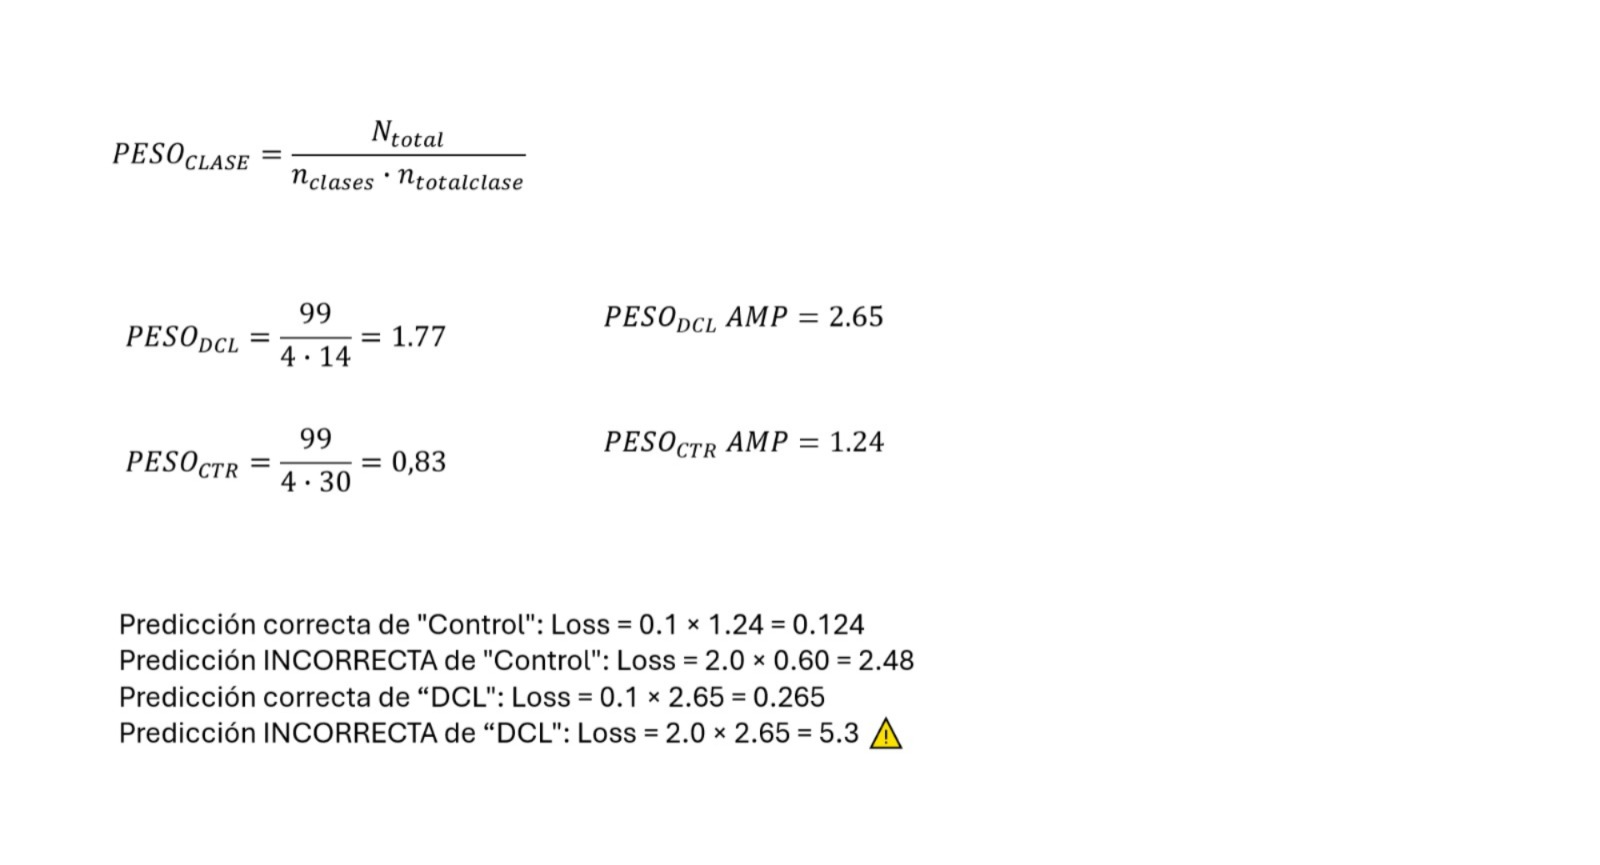

In [ ]:
# =============================================================================
# 10. ENTRENAMIENTO
# =============================================================================
print(f"\n{'='*80}")
print("ENTRENAMIENTO")
print(f"{'='*80}")

history = model.fit(
    X_train, y_train_enc,
    validation_split=0.15,  # Menos validación, más datos para train
    epochs=150,
    batch_size=32,  # Batch más grande para estabilidad
    shuffle=True,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)


ENTRENAMIENTO
Epoch 1/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.3314 - loss: 2.4975 - val_accuracy: 0.4831 - val_loss: 1.2317 - learning_rate: 5.0000e-04
Epoch 2/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.4039 - loss: 1.9359 - val_accuracy: 0.5714 - val_loss: 1.0865 - learning_rate: 5.0000e-04
Epoch 3/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5067 - loss: 1.6210 - val_accuracy: 0.7215 - val_loss: 0.9348 - learning_rate: 5.0000e-04
Epoch 4/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5609 - loss: 1.4701 - val_accuracy: 0.8002 - val_loss: 0.7582 - learning_rate: 5.0000e-04
Epoch 5/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6195 - loss: 1.3067 - val_accuracy: 0.8547 - val_loss: 0.5987 - learning_rate: 5.0000e-04
Epoch 6/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6910 - loss: 1.1021 - val_accuracy: 0.8983 - val_loss: 0.4573 - learning_rate: 5.0000e-04
Epoch 7/150
147/147 ━━━━━━━━━━━━━━━━

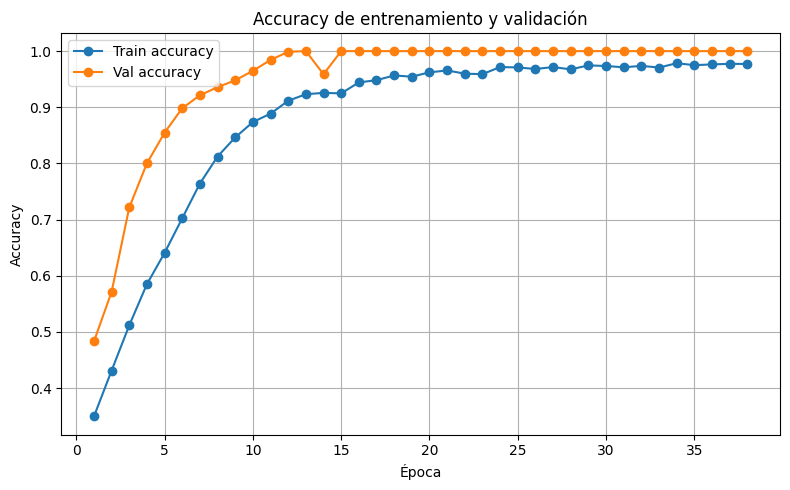

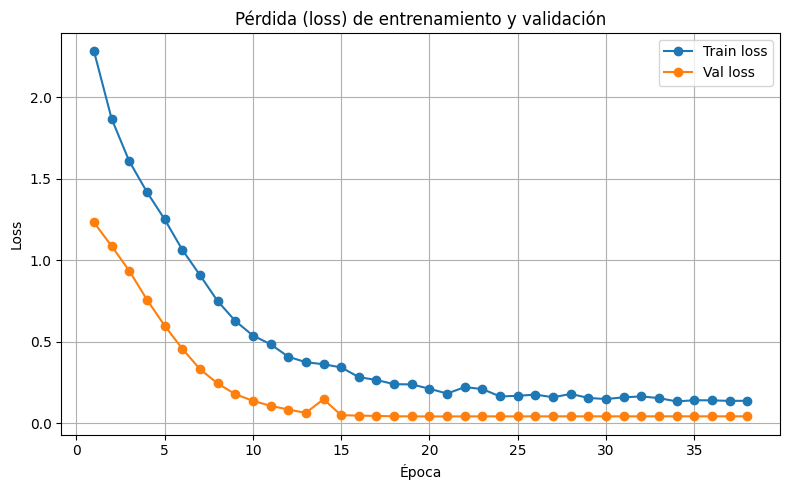

In [ ]:
import matplotlib.pyplot as plt

# ===============================
# GRÁFICAS DE ENTRENAMIENTO
# ===============================

hist = history.history

# Eje x: número de época empezando en 1
epochs = range(1, len(hist["loss"]) + 1)

# 1) Accuracy train / val (puntos + líneas)
plt.figure(figsize=(8, 5))
plt.plot(epochs, hist["accuracy"], marker="o", linestyle="-", label="Train accuracy")
plt.plot(epochs, hist["val_accuracy"], marker="o", linestyle="-", label="Val accuracy")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Accuracy de entrenamiento y validación")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("learning_curve_accuracy.png", dpi=150)
plt.show()

# 2) Loss train / val (puntos + líneas)
plt.figure(figsize=(8, 5))
plt.plot(epochs, hist["loss"], marker="o", linestyle="-", label="Train loss")
plt.plot(epochs, hist["val_loss"], marker="o", linestyle="-", label="Val loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Pérdida (loss) de entrenamiento y validación")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("learning_curve_loss.png", dpi=150)
plt.show()


In [ ]:
# =============================================================================
# 11. EVALUACIÓN POR SECUENCIAS
# =============================================================================
print(f"\n{'='*80}")
print("EVALUACIÓN POR SECUENCIAS")
print(f"{'='*80}")

y_pred_proba = model.predict(X_test, verbose=0)
y_pred = y_pred_proba.argmax(axis=1)

seq_acc = balanced_accuracy_score(y_test_enc, y_pred)
print(f"\nBalanced Accuracy (secuencias): {seq_acc:.4f}")

print("\nMatriz de confusión (secuencias):")
cm = confusion_matrix(y_test_enc, y_pred)
print(cm)

# Normalizada
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("\nMatriz normalizada (% por fila):")
for i, row in enumerate(cm_norm):
    print(f"{le.classes_[i]:5s}: " + " ".join([f"{x:5.1%}" for x in row]))

print("\nReporte de clasificación (secuencias):")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_,
                          zero_division=0))


EVALUACIÓN POR SECUENCIAS

Balanced Accuracy (secuencias): 0.5557

Matriz de confusión (secuencias):
[[36 15 42 11]
 [ 0 30 27  0]
 [ 1 10 72 18]
 [ 3  4 22 51]]

Matriz normalizada (% por fila):
CTR  : 34.6% 14.4% 40.4% 10.6%
DCL  :  0.0% 52.6% 47.4%  0.0%
GG   :  1.0%  9.9% 71.3% 17.8%
GU   :  3.8%  5.0% 27.5% 63.7%

Reporte de clasificación (secuencias):
              precision    recall  f1-score   support

         CTR       0.90      0.35      0.50       104
         DCL       0.51      0.53      0.52        57
          GG       0.44      0.71      0.55       101
          GU       0.64      0.64      0.64        80

    accuracy                           0.55       342
   macro avg       0.62      0.56      0.55       342
weighted avg       0.64      0.55      0.55       342



In [ ]:
# =============================================================================
# 12. EVALUACIÓN POR SUJETO (VOTACIÓN MAYORITARIA)
# =============================================================================
print(f"\n{'='*80}")
print("EVALUACIÓN POR SUJETO (Votación Mayoritaria)")
print(f"{'='*80}")

# Agrupar por sujeto
subject_votes = defaultdict(list)
subject_true_labels = {}

for i, subj in enumerate(test_seq_subjects):
    pred_class = y_pred[i]
    subject_votes[subj].append(pred_class)
    subject_true_labels[subj] = y_test_enc[i]

# Predicción por votación mayoritaria
y_true_subjects = []
y_pred_subjects = []

for subj in subject_votes.keys():
    # Votación mayoritaria
    votes = subject_votes[subj]
    pred_class = Counter(votes).most_common(1)[0][0]

    y_true_subjects.append(subject_true_labels[subj])
    y_pred_subjects.append(pred_class)

y_true_subjects = np.array(y_true_subjects)
y_pred_subjects = np.array(y_pred_subjects)

subj_acc = accuracy_score(y_true_subjects, y_pred_subjects)
subj_bal_acc = balanced_accuracy_score(y_true_subjects, y_pred_subjects)
kappa = cohen_kappa_score(y_true_subjects, y_pred_subjects)

print(f"\nAccuracy (sujetos): {subj_acc:.4f}")
print(f"Balanced Accuracy (sujetos): {subj_bal_acc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

print("\nMatriz de confusión (sujetos):")
cm_subj = confusion_matrix(y_true_subjects, y_pred_subjects)
print(cm_subj)

# Normalizada
cm_subj_norm = cm_subj.astype('float') / cm_subj.sum(axis=1)[:, np.newaxis]
print("\nMatriz normalizada (% por fila):")
for i, row in enumerate(cm_subj_norm):
    print(f"{le.classes_[i]:5s}: " + " ".join([f"{x:5.1%}" for x in row]))

print("\nReporte de clasificación (sujetos):")
print(classification_report(y_true_subjects, y_pred_subjects,
                          target_names=le.classes_, zero_division=0))


EVALUACIÓN POR SUJETO (Votación Mayoritaria)

Accuracy (sujetos): 0.5600
Balanced Accuracy (sujetos): 0.5640
Cohen's Kappa: 0.4086

Matriz de confusión (sujetos):
[[3 1 3 1]
 [0 2 2 0]
 [0 1 5 1]
 [0 0 2 4]]

Matriz normalizada (% por fila):
CTR  : 37.5% 12.5% 37.5% 12.5%
DCL  :  0.0% 50.0% 50.0%  0.0%
GG   :  0.0% 14.3% 71.4% 14.3%
GU   :  0.0%  0.0% 33.3% 66.7%

Reporte de clasificación (sujetos):
              precision    recall  f1-score   support

         CTR       1.00      0.38      0.55         8
         DCL       0.50      0.50      0.50         4
          GG       0.42      0.71      0.53         7
          GU       0.67      0.67      0.67         6

    accuracy                           0.56        25
   macro avg       0.65      0.56      0.56        25
weighted avg       0.68      0.56      0.56        25



In [ ]:
# =============================================================================
# 13. ANÁLISIS DE CONFIANZA
# =============================================================================
print(f"\n{'='*80}")
print("ANÁLISIS DE CONFIANZA DE PREDICCIONES")
print(f"{'='*80}")

# Agrupar probabilidades por sujeto
subject_probas = defaultdict(list)
for i, subj in enumerate(test_seq_subjects):
    subject_probas[subj].append(y_pred_proba[i])

print("\nConfianza promedio por sujeto:")
for subj in sorted(subject_probas.keys()):
    mean_proba = np.mean(subject_probas[subj], axis=0)
    max_conf = mean_proba.max()
    pred_class = le.classes_[mean_proba.argmax()]
    true_class = le.classes_[subject_true_labels[subj]]
    correct = "✓" if pred_class == true_class else "✗"

    print(f"  {subj}: pred={pred_class:5s} (conf={max_conf:.2f}) | "
          f"true={true_class:5s} {correct}")


ANÁLISIS DE CONFIANZA DE PREDICCIONES

Confianza promedio por sujeto:
  sub-CTR005: pred=CTR   (conf=1.00) | true=CTR   ✓
  sub-CTR006: pred=GU    (conf=0.74) | true=CTR   ✗
  sub-CTR008: pred=GG    (conf=0.96) | true=CTR   ✗
  sub-CTR023: pred=CTR   (conf=0.82) | true=CTR   ✓
  sub-CTR025: pred=DCL   (conf=0.97) | true=CTR   ✗
  sub-CTR028: pred=GG    (conf=0.84) | true=CTR   ✗
  sub-CTR030: pred=CTR   (conf=1.00) | true=CTR   ✓
  sub-CTR038: pred=GG    (conf=1.00) | true=CTR   ✗
  sub-DCL003: pred=DCL   (conf=1.00) | true=DCL   ✓
  sub-DCL007: pred=GG    (conf=1.00) | true=DCL   ✗
  sub-DCL010: pred=GG    (conf=0.92) | true=DCL   ✗
  sub-DCL020: pred=DCL   (conf=1.00) | true=DCL   ✓
  sub-GG009: pred=GG    (conf=1.00) | true=GG    ✓
  sub-GG017: pred=GG    (conf=0.70) | true=GG    ✓
  sub-GG019: pred=GG    (conf=0.94) | true=GG    ✓
  sub-GG033: pred=DCL   (conf=0.64) | true=GG    ✗
  sub-GG038: pred=GG    (conf=1.00) | true=GG    ✓
  sub-GG056: pred=GG    (conf=0.99) | true=GG    ✓